# Portfolio Optimization using Unsupervised Learning                                                   

Here , we will use unsupervised Learning(specifically K-means clustering algorithm) and data from S&P 500 stocks to master features , indicators , and portfolio optimization

Lets start by importing necessary libraries.....                          
we will need pandas, numpy, matplotlib, statsmodels, pandas_datareader, datetime, yfinance, sklearn, PyPortfolioOpt

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import statsmodels.api as sm
import pandas_datareader.data as web
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings("ignore")

In [3]:
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


In [4]:
#now lets modify the Symbol column such that whenever there is a "." it gets replaced by "-". 
sp500["Symbol"] = sp500["Symbol"].str.replace("." , "-")

#lets make a list of unique entries on Symbol
symbols_list = sp500["Symbol"].unique().tolist()

end_date = "2023-09-07"

start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8) #used to collect past eight years data.....
#This dataframe will house per-day data of all 500 companies listed on S&P-500 from 2015-09-09 to 2023-09-06 (8yrs)
#by using .stack() it gets packed in nice readable format.....
df = yf.download(tickers = symbols_list , 
                 start = start_date , 
                 end = end_date).stack()

df.index.names = ["date" , "ticker"]
df.columns = df.columns.str.lower() # just for convinence we convert column names to lower case

[*********************100%%**********************]  503 of 503 completed


1 Failed download:
['VLTO']: Exception("%ticker%: Data doesn't exist for startDate = 1441771200, endDate = 1694059200")


## Calculate features and technical indicators for each stock            


*   Garman-Klass Volatility
*   RSI
*   Bollinger Bands
*   ATR
*   MACD
*   Dollar Volume
                                                                        
we will calculate all and add them as columns in df

df.groupby() is used to divide dataframe as specified by the criteria in as paramter.......

In [5]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20)) #dont noralize it

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/(1e6)

In [6]:
df 

adj close       close        high         low        open  \
date       ticker                                                               
2015-09-09 A        33.176929   35.540001   36.799999   35.439999   36.500000   
           AAL      39.097149   41.000000   42.180000   40.630001   41.150002   
           AAPL     24.995981   27.537500   28.504999   27.442499   28.440001   
           ABBV     41.562408   59.259998   61.520000   59.110001   61.520000   
           ABT      36.999706   43.230000   44.509998   43.119999   44.360001   
...                       ...         ...         ...         ...         ...   
2023-09-06 YUM     126.879997  126.879997  128.809998  126.650002  128.300003   
           ZBH     122.404190  122.669998  123.660004  117.500000  117.769997   
           ZBRA    272.380005  272.380005  275.019989  270.190002  273.250000   
           ZION     34.820000   34.820000   35.939999   34.220001   35.599998   
           ZTS     186.860001  186.860001  189.839996  186.360001  189.479996   

                        volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-09 A         1885300.0         -0.002811        NaN       NaN   
           AAL      12481200.0         -0.000311        NaN       NaN   
           AAPL    340043200.0         -0.005715        NaN       NaN   
           ABBV      8436900.0         -0.058611        NaN       NaN   
           ABT       5251200.0         -0.012212        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-06 YUM       1710200.0          0.000095  35.503019  4.845332   
           ZBH       3625200.0          0.000730  44.855038  4.738498   
           ZBRA       327200.0          0.000153  48.523033  5.553782   
           ZION      2945600.0          0.001013  51.041449  3.528409   
           ZTS       1356800.0          0.000096  53.448664  5.194049   

                     bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-09-09 A            NaN       NaN       NaN       NaN      62.548465  
           AAL          NaN       NaN       NaN       NaN     487.979335  
           AAPL         NaN       NaN       NaN       NaN    8499.713440  
           ABBV         NaN       NaN       NaN       NaN     350.657884  
           ABT          NaN       NaN       NaN       NaN     194.292858  
...                     ...       ...       ...       ...            ...  
2023-09-06 YUM     4.875776  4.906219 -0.094865 -1.263327     216.990171  
           ZBH     4.791788  4.845077 -0.166626 -1.396439     443.739670  
           ZBRA    5.596607  5.639433  0.063818 -0.190087      89.122738  
           ZION    3.592922  3.657434 -0.051817  0.166441     102.565791  
           ZTS     5.236936  5.279822  0.795118  0.823438     253.531649  

[993822 rows x 14 columns]

## Aggregate to monthly level and filter top 150 most liquid stocks for each month.

Goal is to filter the 150 most liquid stocks each month. so need to convert date to monthly level....         
To reduce to monthly basis idea is that for garman_klass_vol,rsi,bb_low,bb_mid,bb_high and adj close we take the last value for the month and for dollar volume we take the average for that month.

In [7]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']] #so take only those whose last values will be 
                                                                                   #taken on monthly basis

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()           #we concatenate the both....

data


dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2015-10-31 A           81.152739   35.351627 -1.132061  3.596820  3.508661   
           AAL        435.685795   44.074883  0.947381  3.867002  3.639334   
           AAPL      5217.326990   27.117748 -0.892092  3.344119  3.231976   
           ABBV       459.500771   42.151257  0.520015  3.759811  3.589464   
           ABT        285.804794   38.566082 -0.876093  3.692962  3.550584   
...                          ...         ...       ...       ...       ...   
2023-09-30 OTIS       146.461953   84.389999 -0.780971  4.487069  4.421498   
           ABNB      1530.158509  141.770004 -0.929214  4.959998  4.803707   
           CEG        146.097903  106.639999 -0.910321  4.690942  4.653833   
           GEHC       203.518156   66.949196 -1.087163  4.305898  4.212364   
           KVUE       609.967044   22.379999 -0.801314  3.203983  3.150488   

                     bb_mid  garman_klass_vol      macd        rsi  
date       ticker                                                   
2015-10-31 A       3.552740         -0.001563  0.158472  64.332785  
           AAL     3.753168         -0.000287  1.647543  63.987080  
           AAPL    3.288048         -0.004500 -0.109137  61.709621  
           ABBV    3.674637         -0.037457 -0.509541  59.212685  
           ABT     3.621773         -0.009622  0.319335  63.426332  
...                     ...               ...       ...        ...  
2023-09-30 OTIS    4.454283          0.000066 -0.898395  44.532521  
           ABNB    4.881852          0.000198 -0.001814  58.977174  
           CEG     4.672387          0.000139  0.439278  62.160608  
           GEHC    4.259131          0.000481 -1.535373  29.403237  
           KVUE    3.177236          0.000106  0.156597  37.005004  

[47420 rows x 9 columns]

The next step is to calculate the 5 year rolling average dollar volume for each stock and use this aggregated dollar volume to filter out top 150 most liquid stocks for each month.....

In [8]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack()) #calculating 5yr avg.

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))#ranking in descending order acc to aggregate dollarvol

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1) #filtering in the 150 most liquid stocks
                                                                                    #and then we drop both columns as we not need them anymore
data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2016-09-30 AAL      35.288368 -0.022534  3.656676  3.517487  3.587081   
           AAPL     26.202578 -0.996818  3.348474  3.223032  3.285753   
           ABBV     45.945004 -1.363863  3.882803  3.840018  3.861411   
           ABT      37.085949 -1.057947  3.650061  3.603281  3.626671   
           ACN     108.544632 -0.715097  4.683986  4.564115  4.624050   
...                       ...       ...       ...       ...       ...   
2023-09-30 WFC      41.020000 -0.803757  3.806240  3.724934  3.765587   
           WMT     161.470001  0.273009  5.099852  5.054788  5.077320   
           XOM     114.510002  0.632927  4.746702  4.666474  4.706588   
           MRNA    108.239998 -0.527829  4.812434  4.570113  4.691274   
           ABNB    141.770004 -0.929214  4.959998  4.803707  4.881852   

                   garman_klass_vol      macd        rsi  
date       ticker                                         
2016-09-30 AAL             0.000336  0.005882  53.869394  
           AAPL           -0.001820 -0.076138  59.146437  
           ABBV           -0.037145 -0.370342  43.768439  
           ABT            -0.005227 -0.365088  50.322568  
           ACN            -0.005061  0.121329  68.571088  
...                             ...       ...        ...  
2023-09-30 WFC             0.000182 -0.768063  39.653867  
           WMT             0.000081  0.418250  58.305715  
           XOM             0.000040  1.383425  64.801221  
           MRNA            0.000350 -0.092194  44.928532  
           ABNB            0.000198 -0.001814  58.977174  

[12665 rows x 8 columns]

##  Calculating Monthly returns for different time horizons (1m,2m,3m,6m,9m,12m) and adding them as features
* To capture time series dynamics that reflect , for eg. momentum patterns , we compute historical returns using the method .pct_change(lag) , i.e, returns over various monthly periods as identified by lags.

In [9]:
df.xs("AAPL" , level=1) # AAPL's all features for all dates of loaded data.....

,adj close,close,high,low,open,volume,garman_klass_vol,rsi,bb_low,bb_mid,bb_high,atr,macd,dollar_volume
date,,,,,,,,,,,,,,
2015-09-09,24.995981,27.537500,28.504999,27.442499,28.440001,340043200.0,-0.005715,NaN,NaN,NaN,NaN,NaN,NaN,8499.713440
2015-09-10,25.545145,28.142500,28.320000,27.475000,27.567499,251571200.0,-0.001784,NaN,NaN,NaN,NaN,NaN,NaN,6426.422791
2015-09-11,25.917305,28.552500,28.552500,27.940001,27.947500,199662000.0,-0.001962,NaN,NaN,NaN,NaN,NaN,NaN,5174.700949
2015-09-14,26.166918,28.827499,29.222500,28.715000,29.145000,233453600.0,-0.004335,NaN,NaN,NaN,NaN,NaN,NaN,6108.761162
2015-09-15,26.387039,29.070000,29.132500,28.605000,28.982500,173364800.0,-0.003233,NaN,NaN,NaN,NaN,NaN,NaN,4574.583771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-30,187.649994,187.649994,187.850006,184.740005,184.940002,60813900.0,0.000058,56.371718,5.150220,5.194761,5.239301,0.853789,-0.899507,11411.727964
2023-08-31,187.869995,187.869995,189.119995,187.479996,187.839996,60794500.0,0.000038,56.618188,5.153535,5.193962,5.234388,0.774524,-0.568095,11421.462418
2023-09-01,189.460007,189.460007,189.919998,188.279999,189.490005,45732600.0,0.000038,58.405828,5.149201,5.196029,5.242858,0.719817,-0.240164,8664.498703


In [10]:
# To calculate returns of basis of lags(1m , 2m , 3m , 6m , 9m , 12m) we define a function
def calculate_returns(df):

#since we are dealing with many stocks there will definately be outliner values in the return of those stocks. so we deal with them by clipping 
#   them. so for values above this cutoff we clip it to this value.....    
    outlier_cutoff = 0.005 

    lags = [1, 2, 3, 6, 9, 12]  # we are going to calculate lags for these following months          

    for lag in lags:
        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff), #we  use the clip here....
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()  #we use groupby,apply to apply this fn to whole df
data


adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2017-09-30 AAL      46.185764  0.484861  3.876266  3.764263  3.820264   
           AAPL     36.351837 -0.893977  3.689675  3.594099  3.641887   
           ABBV     67.243973 -0.270744  4.281793  4.077986  4.179889   
           ABT      47.949158 -0.957762  3.892186  3.840507  3.866346   
           ACN     122.512245 -0.874783  4.853249  4.782229  4.817739   
...                       ...       ...       ...       ...       ...   
2023-09-30 WFC      41.020000 -0.803757  3.806240  3.724934  3.765587   
           WMT     161.470001  0.273009  5.099852  5.054788  5.077320   
           XOM     114.510002  0.632927  4.746702  4.666474  4.706588   
           MRNA    108.239998 -0.527829  4.812434  4.570113  4.691274   
           ABNB    141.770004 -0.929214  4.959998  4.803707  4.881852   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2017-09-30 AAL            -0.000215  0.353649  53.050750   0.061466   
           AAPL           -0.000959 -0.461494  45.768873  -0.060244   
           ABBV           -0.029421  1.296292  70.568487   0.180079   
           ABT            -0.004815  0.382373  63.665006   0.047507   
           ACN            -0.004568  0.193102  56.250086   0.032961   
...                             ...       ...        ...        ...   
2023-09-30 WFC             0.000182 -0.768063  39.653867  -0.006539   
           WMT             0.000081  0.418250  58.305715  -0.007011   
           XOM             0.000040  1.383425  64.801221   0.029859   
           MRNA            0.000350 -0.092194  44.928532  -0.042717   
           ABNB            0.000198 -0.001814  58.977174   0.077689   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-09-30 AAL     -0.028700  -0.018447   0.020186   0.002602    0.022680  
           AAPL     0.019956   0.024187   0.013139   0.033672    0.027658  
           ABBV     0.125238   0.073326   0.056376   0.042995    0.032249  
           ABT      0.041630   0.033465   0.033071   0.039285    0.021639  
           ACN      0.023971   0.029801   0.021839   0.017126    0.010139  
...                      ...        ...        ...        ...         ...  
2023-09-30 WFC     -0.053639  -0.010570   0.018249   0.001710    0.004013  
           WMT      0.006808   0.010211   0.016496   0.015835    0.019716  
           XOM      0.037567   0.024858   0.010064   0.006905    0.025630  
           MRNA    -0.040866  -0.037789  -0.056644  -0.054723   -0.007344  
           ABNB    -0.034840   0.034214   0.022023   0.056795    0.025304  

[10484 rows x 14 columns]

## Download Fama-French factors and calculating the Rolling factor betas 
* We will add more defining features by introducing these factors
1. Fama-French factors to estimate the exposure of assets to common risk factors using linear regression.                                      
   The five Fama-French factors, viz. market risk,size,value,operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.                                                                                         
   
We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling   linear  regression.

In [11]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',  #downloading the fama-french factors data
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1) 
# now we convert to the format we want
factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100) # to convert in our date format
                                                        # and to convert data in numbers since original data is in percentages
factor_data.index.name = 'date'

#now we join this data to return_1m since while calculating beta we will use rollingols(linear regression) and as beta is predictive and we
#know betas in beginning of the month and return at the end so we can regress it to the end of the month(so used the return_1m) by using 
#RollingOLS
factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-09-30 AAL     0.0251  0.0478  0.0314 -0.0147  0.0169   0.061466
           AAPL    0.0251  0.0478  0.0314 -0.0147  0.0169  -0.060244
           ABBV    0.0251  0.0478  0.0314 -0.0147  0.0169   0.180079
           ABT     0.0251  0.0478  0.0314 -0.0147  0.0169   0.047507
           ACN     0.0251  0.0478  0.0314 -0.0147  0.0169   0.032961
...                   ...     ...     ...     ...     ...        ...
2023-07-31 VZ      0.0321  0.0286  0.0413 -0.0056  0.0062  -0.067220
           WFC     0.0321  0.0286  0.0413 -0.0056  0.0062   0.081537
           WMT     0.0321  0.0286  0.0413 -0.0056  0.0062   0.017051
           WYNN    0.0321  0.0286  0.0413 -0.0056  0.0062   0.031910
           XOM     0.0321  0.0286  0.0413 -0.0056  0.0062  -0.000093

[10193 rows x 6 columns]

Now , we filter out stocks with less than 10 months of data

In [12]:
observations = factor_data.groupby(level=1).size()
valid_stocks = observations[observations >= 10]
#now we filter out the unneeded stocks from factor_data 
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-09-30 AAL     0.0251  0.0478  0.0314 -0.0147  0.0169   0.061466
           AAPL    0.0251  0.0478  0.0314 -0.0147  0.0169  -0.060244
           ABBV    0.0251  0.0478  0.0314 -0.0147  0.0169   0.180079
           ABT     0.0251  0.0478  0.0314 -0.0147  0.0169   0.047507
           ACN     0.0251  0.0478  0.0314 -0.0147  0.0169   0.032961
...                   ...     ...     ...     ...     ...        ...
2023-07-31 VZ      0.0321  0.0286  0.0413 -0.0056  0.0062  -0.067220
           WFC     0.0321  0.0286  0.0413 -0.0056  0.0062   0.081537
           WMT     0.0321  0.0286  0.0413 -0.0056  0.0062   0.017051
           WYNN    0.0321  0.0286  0.0413 -0.0056  0.0062   0.031910
           XOM     0.0321  0.0286  0.0413 -0.0056  0.0062  -0.000093

[10137 rows x 6 columns]

In [13]:
from statsmodels.regression.rolling import RollingOLS
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)   #fit with the above data
         .params
         .drop('const', axis=1)))

betas 

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-09-30 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-07-31 VZ      0.328748 -0.082248  0.244748  0.261142  0.175841
           WFC     1.065927  0.205756  2.083804 -0.248225 -1.631918
           WMT     0.774864 -0.183055 -0.580121 -0.202141  0.755489
           WYNN    1.099833  0.096335  0.042646  0.348799 -0.029272
           XOM     0.986831 -0.752199  1.460374 -0.633452  0.098030

[10137 rows x 5 columns]

Now , its time to join with our original dataframe(data) these additional features beta                                       
NOTE: but since we have found out the betas using regression, at the end of month so the beta value are actually lagging behind our main data dataframe's date by one month so first we need to shift them one month forward . eg. we would know the rolling 

In [14]:
factors = ["Mkt-RF" , "SMB" , "HML" , "RMW" , "CMA" ]

data = data.join((betas.groupby("ticker").shift()))
data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean())) #we fillmissingfactorvaluesbyavg

data = data.drop('adj close', axis=1) # dont't need it anymore

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10177 entries, (Timestamp('2017-09-30 00:00:00'), 'AAL') to (Timestamp('2023-09-30 00:00:00'), 'MRNA')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               10177 non-null  float64
 1   bb_high           10177 non-null  float64
 2   bb_low            10177 non-null  float64
 3   bb_mid            10177 non-null  float64
 4   garman_klass_vol  10177 non-null  float64
 5   macd              10177 non-null  float64
 6   rsi               10177 non-null  float64
 7   return_1m         10177 non-null  float64
 8   return_2m         10177 non-null  float64
 9   return_3m         10177 non-null  float64
 10  return_6m         10177 non-null  float64
 11  return_9m         10177 non-null  float64
 12  return_12m        10177 non-null  float64
 13  Mkt-RF            10177 non-null  float64
 14  SMB               10177 non-null  float64
 15  HML       

At this point we have loaded and processed our data so we now have to choose which ML model we will use for predictions....

## For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
we will use it to predict what stocks we should keep in our portfolio and also the relative weights of the stocks.                                                                                                                          
After some trial and error we see that n_clusters = 4 works best....

In [15]:
#data = data.drop("cluster" , axis = 1)
data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2017-09-30 AAL     0.484861  3.876266  3.764263  3.820264         -0.000215   
           AAPL   -0.893977  3.689675  3.594099  3.641887         -0.000959   
           ABBV   -0.270744  4.281793  4.077986  4.179889         -0.029421   
           ABT    -0.957762  3.892186  3.840507  3.866346         -0.004815   
           ACN    -0.874783  4.853249  4.782229  4.817739         -0.004568   
...                     ...       ...       ...       ...               ...   
2023-09-30 VZ     -0.962056  3.563164  3.485292  3.524228         -0.000050   
           WFC    -0.803757  3.806240  3.724934  3.765587          0.000182   
           WMT     0.273009  5.099852  5.054788  5.077320          0.000081   
           XOM     0.632927  4.746702  4.666474  4.706588          0.000040   
           MRNA   -0.527829  4.812434  4.570113  4.691274          0.000350   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2017-09-30 AAL     0.353649  53.050750   0.061466  -0.028700  -0.018447   
           AAPL   -0.461494  45.768873  -0.060244   0.019956   0.024187   
           ABBV    1.296292  70.568487   0.180079   0.125238   0.073326   
           ABT     0.382373  63.665006   0.047507   0.041630   0.033465   
           ACN     0.193102  56.250086   0.032961   0.023971   0.029801   
...                     ...        ...        ...        ...        ...   
2023-09-30 VZ      0.410134  51.881153  -0.022870   0.001466  -0.021974   
           WFC    -0.768063  39.653867  -0.006539  -0.053639  -0.010570   
           WMT     0.418250  58.305715  -0.007011   0.006808   0.010211   
           XOM     1.383425  64.801221   0.029859   0.037567   0.024858   
           MRNA   -0.092194  44.928532  -0.042717  -0.040866  -0.037789   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-09-30 AAL      0.020186   0.002602    0.022680  1.271195  1.294582   
           AAPL     0.013139   0.033672    0.027658  1.267362 -0.264960   
           ABBV     0.056376   0.042995    0.032249  0.501101  0.346992   
           ABT      0.033071   0.039285    0.021639  0.833625 -0.214520   
           ACN      0.021839   0.017126    0.010139  1.192323 -0.157634   
...                      ...        ...         ...       ...       ...   
2023-09-30 VZ      -0.015699  -0.010211   -0.003219  0.523463 -0.362042   
           WFC      0.018249   0.001710    0.004013  1.098983 -0.143674   
           WMT      0.016496   0.015835    0.019716  0.619052 -0.477576   
           XOM      0.010064   0.006905    0.025630  1.172388  0.386248   
           MRNA    -0.056644  -0.054723   -0.007344  1.301327 -0.186763   

                        HML       RMW       CMA  
date       ticker                                
2017-09-30 AAL     0.641576  0.540057  0.537713  
           AAPL   -0.606126  0.667396  0.430477  
           ABBV   -0.008682  0.174947  0.108644  
           ABT    -0.536210  0.230959  0.976360  
           ACN    -0.333312  0.259654  0.171308  
...                     ...       ...       ...  
2023-09-30 VZ      0.002400  0.321602  0.648179  
           WFC     1.288775 -0.749694 -0.375765  
           WMT    -0.280780  0.430778  0.724894  
           XOM     0.494599 -0.468298  0.813785  
           MRNA   -1.183057  1.125993  0.527068  

[10177 rows x 18 columns]

In [16]:
from sklearn.cluster import KMeans

# def get_clusters(df):
#     df["cluster"] = KMeans(n_clusters = 4 , random_state = 0 , init = 'random').fit(df).labels_
#     return df
# data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)
'''
we commented the above code because we want to invest based on the momentum of the stocks and we will use rsi as a measure of the momentum so 
we would want to invest in those stocks which have high momentum(or rsi of 65-75) but random initalization would not work and we will 
assign the inital cluster centers ourselves based on rsi values.....
note that the array must be of shape (n_clusters , n_features)
'''
#Apply pre-defined centeriods.......
target_rsi_values = [30 , 45 , 55 , 70]
initial_centroids = np.zeros((len(target_rsi_values) , 18))
initial_centroids[: , 6] = target_rsi_values # since the 7th column is rsi so in feature space it has index equal to 6

def get_clusters(df):
    df["cluster"] = KMeans(n_clusters = 4 , random_state = 0 , init = initial_centroids).fit(df).labels_
    return df
data = data.dropna().groupby('date', group_keys=False).apply(get_clusters) #so function is applied month-wise

data
#so now cluster-3 is assigned to our favourable rsi values with center around 70......

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2017-09-30 AAL     0.484861  3.876266  3.764263  3.820264         -0.000215   
           AAPL   -0.893977  3.689675  3.594099  3.641887         -0.000959   
           ABBV   -0.270744  4.281793  4.077986  4.179889         -0.029421   
           ABT    -0.957762  3.892186  3.840507  3.866346         -0.004815   
           ACN    -0.874783  4.853249  4.782229  4.817739         -0.004568   
...                     ...       ...       ...       ...               ...   
2023-09-30 VZ     -0.962056  3.563164  3.485292  3.524228         -0.000050   
           WFC    -0.803757  3.806240  3.724934  3.765587          0.000182   
           WMT     0.273009  5.099852  5.054788  5.077320          0.000081   
           XOM     0.632927  4.746702  4.666474  4.706588          0.000040   
           MRNA   -0.527829  4.812434  4.570113  4.691274          0.000350   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2017-09-30 AAL     0.353649  53.050750   0.061466  -0.028700  -0.018447   
           AAPL   -0.461494  45.768873  -0.060244   0.019956   0.024187   
           ABBV    1.296292  70.568487   0.180079   0.125238   0.073326   
           ABT     0.382373  63.665006   0.047507   0.041630   0.033465   
           ACN     0.193102  56.250086   0.032961   0.023971   0.029801   
...                     ...        ...        ...        ...        ...   
2023-09-30 VZ      0.410134  51.881153  -0.022870   0.001466  -0.021974   
           WFC    -0.768063  39.653867  -0.006539  -0.053639  -0.010570   
           WMT     0.418250  58.305715  -0.007011   0.006808   0.010211   
           XOM     1.383425  64.801221   0.029859   0.037567   0.024858   
           MRNA   -0.092194  44.928532  -0.042717  -0.040866  -0.037789   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-09-30 AAL      0.020186   0.002602    0.022680  1.271195  1.294582   
           AAPL     0.013139   0.033672    0.027658  1.267362 -0.264960   
           ABBV     0.056376   0.042995    0.032249  0.501101  0.346992   
           ABT      0.033071   0.039285    0.021639  0.833625 -0.214520   
           ACN      0.021839   0.017126    0.010139  1.192323 -0.157634   
...                      ...        ...         ...       ...       ...   
2023-09-30 VZ      -0.015699  -0.010211   -0.003219  0.523463 -0.362042   
           WFC      0.018249   0.001710    0.004013  1.098983 -0.143674   
           WMT      0.016496   0.015835    0.019716  0.619052 -0.477576   
           XOM      0.010064   0.006905    0.025630  1.172388  0.386248   
           MRNA    -0.056644  -0.054723   -0.007344  1.301327 -0.186763   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-09-30 AAL     0.641576  0.540057  0.537713        1  
           AAPL   -0.606126  0.667396  0.430477        1  
           ABBV   -0.008682  0.174947  0.108644        3  
           ABT    -0.536210  0.230959  0.976360        2  
           ACN    -0.333312  0.259654  0.171308        2  
...                     ...       ...       ...      ...  
2023-09-30 VZ      0.002400  0.321602  0.648179        2  
           WFC     1.288775 -0.749694 -0.375765        0  
           WMT    -0.280780  0.430778  0.724894        2  
           XOM     0.494599 -0.468298  0.813785        3  
           MRNA   -1.183057  1.125993  0.527068        1  

[10177 rows x 19 columns]

In [17]:
#Code to plot clusters.......
'''
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]         #takes all rows which lie in cluster_0
    cluster_1 = data[data['cluster']==1]         #takes all rows which lie in cluster_1
    cluster_2 = data[data['cluster']==2]         #takes all rows which lie in cluster_2
    cluster_3 = data[data['cluster']==3]         #takes all rows which lie in cluster_3

    #plot all four cluster in a scatter plot
    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return

plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)


'''

"\ndef plot_clusters(data):\n\n    cluster_0 = data[data['cluster']==0]         #takes all rows which lie in cluster_0\n    cluster_1 = data[data['cluster']==1]         #takes all rows which lie in cluster_1\n    cluster_2 = data[data['cluster']==2]         #takes all rows which lie in cluster_2\n    cluster_3 = data[data['cluster']==3]         #takes all rows which lie in cluster_3\n\n    #plot all four cluster in a scatter plot\n    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'red', label='cluster 0')\n    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'green', label='cluster 1')\n    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')\n    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'black', label='cluster 3')\n    \n    plt.legend()\n    plt.show()\n    return\n\nplt.style.use('ggplot')\n\nfor i in data.index.get_level_values('date').unique().tolist():\n    \n    g = data.xs(i, level=0)\

## For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization
First, we will filter only stocks corresponding to the cluster we choose based on our hypothesis which is that Momentum is persistent and idea would be that stocks clustered around rsi 70 centroid should continue to outperform in the following month - thus we would select stocks corresponding to cluster-3

Now what we do is that we would make a dictionary(named fixed_dates) in which the keys will be dates of coming months and their correspondings values would be all the stocks that we can invest on(not the weights...only names) and they are those which are in cluster-3             
So, since we have data from sept-2017 we would predict from that on month data, the prediction of next month i.e. oct-2017 and so-on....

In [18]:
filtered_df = data[data["cluster"] == 3].copy()
filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1) #we want dates of one coming month so offset=1..... 

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates #This is the required dictionary........

{'2017-10-01': ['ABBV',
  'AMAT',
  'AXP',
  'BA',
  'BMY',
  'C',
  'CAT',
  'COP',
  'CVX',
  'DLTR',
  'EOG',
  'F',
  'FDX',
  'GM',
  'HAL',
  'HD',
  'INTC',
  'MAR',
  'MET',
  'MU',
  'OXY',
  'SCHW',
  'SLB',
  'TXN',
  'UNP',
  'UPS',
  'VLO',
  'WFC',
  'XOM'],
 '2017-11-01': ['AAPL',
  'ACN',
  'ADBE',
  'AMAT',
  'AMZN',
  'AVGO',
  'AXP',
  'BAC',
  'CAT',
  'COP',
  'CRM',
  'CTSH',
  'DE',
  'DHR',
  'DLTR',
  'ELV',
  'EOG',
  'GOOG',
  'GOOGL',
  'INTC',
  'ISRG',
  'JPM',
  'MA',
  'MAR',
  'MCD',
  'MET',
  'META',
  'MMM',
  'MSFT',
  'MU',
  'NEE',
  'NVDA',
  'NXPI',
  'ORCL',
  'PYPL',
  'SHW',
  'TXN',
  'UNH',
  'V',
  'VLO',
  'WMT',
  'XOM'],
 '2017-12-01': ['AMZN',
  'AXP',
  'AZO',
  'BA',
  'BAC',
  'BLK',
  'BRK-B',
  'CAT',
  'COST',
  'CSCO',
  'DE',
  'DLTR',
  'ELV',
  'HD',
  'HON',
  'ILMN',
  'JPM',
  'KR',
  'LUV',
  'MAR',
  'MMM',
  'NKE',
  'ORLY',
  'OXY',
  'SCHW',
  'UNH',
  'UNP',
  'VLO',
  'VZ',
  'WMT'],
 '2018-01-01': ['BA',
  'CAT',
 

### Define Portfolio optimization function
Now we will define a function which optimizes portfolio weights using  PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio......                                                                                      
* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function...so we will import it using yfinance from oct-2016 t0 sep-2023 and will name as new_df....                                              
* We will also apply single stock weight bounds constraints for diversification(lower bound as half of equaly weight and upper bound as 10% of portfolio)

In [32]:
#so we have the list of companies we want to invest in as fixed_dates and our task now is to assign weights to them..

from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices , lower_bound = 0): 
# we passed in lower bound as a param as we want a uniform weight distribution in optimization[see point above]
# we can also make upper bound as a param......... 
    returns = expected_returns.mean_historical_return(prices=prices , frequency=352)
    #coefficient of variance(cov)
    cov = risk_models.sample_cov(prices=prices , frequency=352)

    ef = EfficientFrontier(expected_returns=returns , cov_matrix=cov , weight_bounds=(lower_bound , 0.1) , solver="SCS")

    weights = ef.max_sharpe()

    return ef.clean_weights()


Now we download fresh daily prices only for short listed stocks(starting from one year prior)                   
This new_df is just like the df but for different dates so it has same columns

In [33]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  153 of 153 completed


Adj Close                                                 \
                  AAL        AAPL        ABBV        ABT         ACN   
Date                                                                   
2016-09-30  35.288372   26.202578   45.945011  37.085953  108.544632   
2016-10-03  36.339024   26.079733   46.061554  37.313946  107.380737   
2016-10-04  36.271545   26.190981   45.894016  36.919319  105.052956   
2016-10-05  36.502892   26.202578   46.178127  37.480579  105.026299   
2016-10-06  36.792053   26.397270   45.770180  37.682270  105.301720   
...               ...         ...         ...        ...         ...   
2023-09-25  12.910000  176.080002  153.117371  96.933411  315.680695   
2023-09-26  12.700000  171.960007  152.384705  95.700241  309.327057   
2023-09-27  12.610000  170.429993  151.612442  95.004089  313.081512   
2023-09-28  12.920000  170.690002  150.741165  97.579834  299.527710   
2023-09-29  12.810000  171.210007  147.582764  96.316818  305.841522   

                                                                       ...  \
                  ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2016-09-30  108.540001   76.122711   72.330002  49.292889   27.741913  ...   
2016-10-03  108.449997   75.630760   71.180000  48.944004   27.530287  ...   
2016-10-04  108.389999   75.233734   71.419998  49.076912   27.245047  ...   
2016-10-05  108.800003   75.587608   73.209999  49.758080   27.548685  ...   
2016-10-06  108.559998   75.570320   72.830002  49.799606   27.502678  ...   
...                ...         ...         ...        ...         ...  ...   
2023-09-25  511.600006  240.020004  205.669998  62.130001  136.589996  ...   
2023-09-26  506.299988  237.240005  201.660004  61.259998  134.080002  ...   
2023-09-27  502.600006  242.630005  202.279999  61.009998  135.059998  ...   
2023-09-28  504.670013  243.309998  207.889999  61.279999  138.220001  ...   
2023-09-29  509.899994  240.580002  206.910004  60.599998  138.449997  ...   

             Volume                                                           \
                  V      VLO     VRTX        VZ       WBA      WDC       WFC   
Date                                                                           
2016-09-30  9776800  8318600  2545700  13077600   4490200  4396800  54117700   
2016-10-03  8155400  5172200  1371300   9120300   2306200  5163900  38197700   
2016-10-04  5772000  5804000  1081100  13753300   3111600  4601200  44008300   
2016-10-05  6163400  6393900   964400  17190900   2498200  4442000  40459000   
2016-10-06  7687100  4045600  1375000  11724000   3661700  4964600  29878200   
...             ...      ...      ...       ...       ...      ...       ...   
2023-09-25  5921600  3241900   698100  17616900   6891000  2685900  10624000   
2023-09-26  6193200  4936800   633600  18841600   7570500  3571100  15219400   
2023-09-27  6006700  3644000   860600  22083500  10182900  2547800  11815500   
2023-09-28  4203900  3587300   578900  18772100   7291500  3282000  12454600   
2023-09-29  6044200  4302200   896800  19759400  25659100  2512000  13119100   

                                         
                 WMT     WYNN       XOM  
Date                                     
2016-09-30   9982600  6737900  15961500  
2016-10-03   5857700  4234900   7111200  
2016-10-04   6569300  3288400   8222000  
2016-10-05   6464400  2699600   8796200  
2016-10-06  20110300  1969200   7718300  
...              ...      ...       ...  
2023-09-25   3486500  1387800  11316000  
2023-09-26   4811900  1454000  11805400  
2023-09-27   5237000  2050000  23976200  
2023-09-28   3872400  1290400  16808100  
2023-09-29   6279300  1326800  18810700  

[1761 rows x 918 columns]

Now we will do the following:
* 1. calculate daily returns for each stock which end up in our portfolio
* 2. Then loop over each month start, select the stocks for the month and calculate their weights for next month
* 3. If the maximum sharpe ratio optimization fails for the month(due to unavailable data) , apply equally-weighted
     weights.
* 4. calculate each day portfolio return.

In [34]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df

Max Sharpe Optimization failed for 2018-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2019-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2020-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2021-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2022-10-01, Continuing with Equal-Weights
'return'


,Strategy Return
date,
2017-10-02,0.006453
2017-10-03,0.000610
2017-10-04,-0.002155
2017-10-05,0.004683
2017-10-06,0.002329
...,...
2023-09-25,0.003604
2023-09-26,-0.011205
2023-09-27,0.004882


## Visualize Portfolio returns and compare to SP500 returns.

In [35]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold
2017-10-02,0.006453,0.004329
2017-10-03,0.000610,0.002138
2017-10-04,-0.002155,0.001186
2017-10-05,0.004683,0.005908
2017-10-06,0.002329,-0.001140
...,...,...
2023-09-25,0.003604,0.004196
2023-09-26,-0.011205,-0.014800
2023-09-27,0.004882,0.000399
2023-09-28,0.007849,0.005781


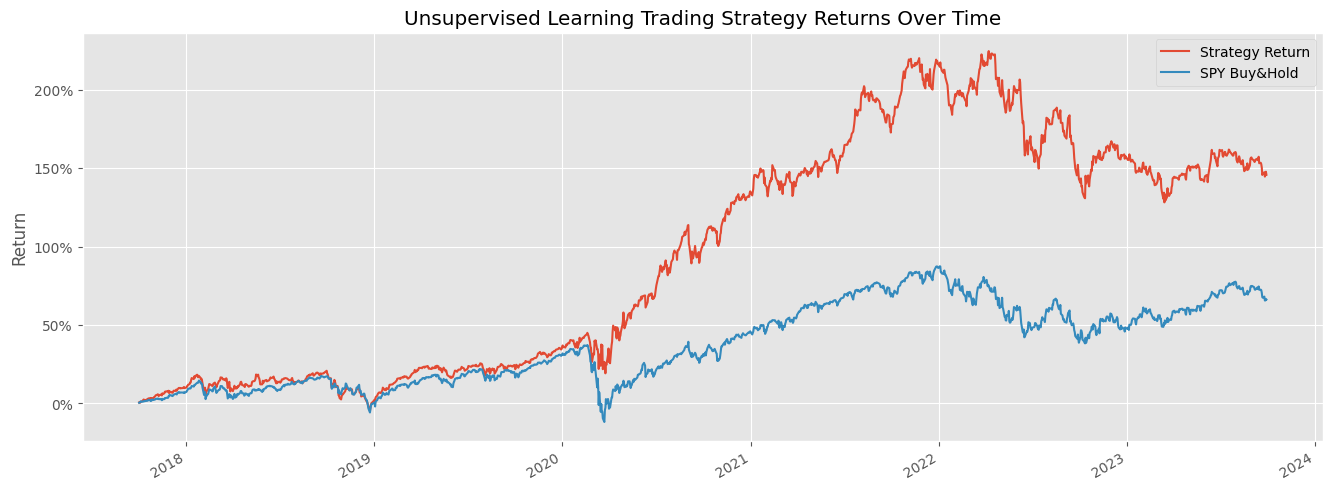

In [36]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()